In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import glob
import toml

from qd_analysis.util import load_example_frames
from tqdm.auto import tqdm

In [3]:
config = toml.load("../preprocessing/config.toml")

In [4]:
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

In [5]:
vid_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/"

In [6]:
csv= os.path.join(config["dirs"]["data"], "misc/qdot_800_excitation_chroma_viewer.csv")
led_excel = os.path.join(config["dirs"]["data"], "misc/advanced_illumination_led_data.xlsx")

In [7]:
df = pd.read_csv(csv).set_index("Wavelength")

In [8]:
lights = {"new_660": "094111",
          "old_730": "095051"}

In [9]:
led_dfs = []
for _light_name, _sheet_name in lights.items():
    _df = pd.read_excel(led_excel, sheet_name=_sheet_name)
    _df["light_name"] = _light_name
    led_dfs.append(_df)

In [10]:
led_df = pd.concat(led_dfs)
led_df = led_df.set_index("Wavelength (nm)")

In [11]:
sns.set_context("paper")

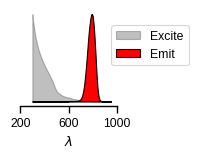

In [12]:
fig, ax = plt.subplots(1, figsize=(1.25,1.25))
ax.fill_between(df.index, df["Excitation"].values, fc="k", ec="k",alpha=.25, label="Excite")
ax.fill_between(df.index, df["Emission"].values, fc="r", ec="k", label="Emit")
ax.legend(bbox_to_anchor=(1.8, .9))
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_yticks([])
ax.set_xticks([200,600,1000])
ax.set_xlabel("$\lambda$")
fig.savefig(os.path.join(fig_dir, "qdot800_spectra_thermo.pdf"), bbox_inches="tight")
# sns.despine(offset=5)


In [13]:
show_lights = ["old_730", "new_660"]

In [14]:
new_df = led_df.query("light_name == 'old_730'")
fwhm = new_df.loc[new_df["Relative Irradiance"] > .5].index

In [15]:
edges = (fwhm.min(), fwhm.max())

In [16]:
from scipy import integrate

In [17]:
vals = led_df.groupby("light_name").idxmax()
idxs = df["Excitation"].index.get_indexer(vals.to_numpy().squeeze(), method="nearest")
yidxs = df["Excitation"].iloc[idxs]

In [18]:
colors = {
    "new_660": [.7, 0, 0],
    "old_730": [1, 0, 0]
}

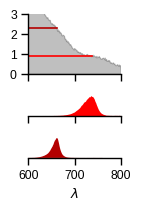

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(1.5,2.2), height_ratios=[3, 1, 1], sharex=True, sharey=False)

ax[0].fill_between(df.index, df["Excitation"].values, fc="k", ec="k",alpha=.25, label="Excite")
for _ax, _light in zip(ax[1:], show_lights):
    plt_df = led_df.query("light_name == @_light")
    _ax.fill_between(plt_df.index, plt_df["Relative Irradiance"] * 100, fc=colors[_light], ec=None)

ax[0].set_ylim(0, 3)
ax[0].set_yticks(np.arange(3.1))
for (_light, _val), _yidx in zip(vals.iterrows(), yidxs):
    ax[0].plot([0, _val.iat[0]], [_yidx] * 2, color=colors[_light])
# ax.legend(bbox_to_anchor=(1.8, .9))
for _ax in ax:
    _ax.spines[["right", "top"]].set_visible(False)
for _ax in ax[1:]:
    _ax.spines["left"].set_visible(False)
    _ax.set_ylim(0, 100)
    _ax.set_yticks([])
    # _ax.set(yticklength=0)
ax[-1].set_xticks(np.arange(500, 801, 100))
ax[-1].set_xlabel("$\lambda$")
ax[-1].set_xlim(600, 800)

fig.tight_layout()
fig.savefig(os.path.join(fig_dir, "qdot800_spectra_thermo_excitation_lights_highlighted.pdf"), bbox_inches="tight")

In [20]:
exp_decay = lambda x, tau: np.exp(-x/tau)

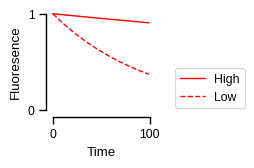

In [21]:
fig, ax = plt.subplots(1, figsize=(1.25, 1.25))
ax.plot(exp_decay(np.arange(100), 1000), clip_on=False, color="r", lw=1, label="High")
ax.plot(exp_decay(np.arange(100), 100), clip_on=False, color="r", ls="--", lw=1, label="Low")
ax.spines[["top","right"]].set_visible(False)
ax.set_yticks([0,1])
ax.set_ylim(0,1)
ax.set_xticks([0, 100])
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_xlabel("Time")
ax.set_ylabel("Fluoresence")
ax.legend(bbox_to_anchor=(1.2, .5))
sns.despine(offset=5)
fig.savefig(os.path.join(fig_dir, "qdot_photostability.pdf"), bbox_inches="tight")


In [22]:
# temporal multiplexing

In [23]:
# load in metadata file and use to derive schematic...

# plot cycle time for slow/fast exposures

In [24]:
ncycles = 3
cycle_type = "slow"

In [25]:
if cycle_type == "slow":
    metadata_fname = os.path.join(vid_dir, "timecourse_01/session_20231204114743-438357 (system76-pc)/metadata.toml")
    calibration_data = toml.load(os.path.join(vid_dir, "timecourse_01_calibration.toml"))
    fluo_dir = "/storage/home/hcoda1/4/jmarkowitz30/shared_folder/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/timecourse_01/session_20231204114743-438357 (system76-pc)/_proc"
else:
    metadata_fname = "/storage/coda1/p-jmarkowitz30/0/shared/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/sciadv_rebuttal/exposure_series/session_20250515170340-837930 (system76-pc)/metadata.toml"
    calibration_data = toml.load(os.path.join(vid_dir, "timecourse_04_calibration.toml"))
    fluo_dir = "/storage/coda1/p-jmarkowitz30/0/shared/active_lab_members/markowitz_jeffrey/active_projects/quantum_dots/sciadv_rebuttal/exposure_series/session_20250515170340-837930 (system76-pc)/_proc"
    

In [26]:
use_cameras = [
    "Basler-267601741000-24383488",
    "Basler-267601746219-24404505",
    "Basler-267601746223-24404515",
    "Basler-26760175421F-24461855",
    "Basler-2676017611A4-24514980",
]

In [27]:
metadata = toml.load(metadata_fname)

In [28]:
trigger_hi = np.array(metadata["cli_parameters"]["hw_trigger_pulse_width"]) # reflect then fluo
trigger_lo = np.array(metadata["cli_parameters"]["hw_trigger_pulse_low"])

In [29]:
fluo_to_reflect_time = np.sum(trigger_hi / 2) + trigger_lo[0]

In [30]:
fluo_to_fluo_time = np.sum(trigger_hi) + np.sum(trigger_lo)

In [31]:
fs = 5000
samples_hi = {}
samples_lo = {}
samples_hi["reflect"] = np.round(trigger_hi[0] * fs).astype("int")
samples_hi["fluo"] = np.round(trigger_hi[1] * fs).astype("int")
samples_lo["reflect"] = np.round(trigger_lo[0] * fs).astype("int")
samples_lo["fluo"] = np.round(trigger_lo[1] * fs).astype("int")

In [32]:
# one cycle is hi then lo then other hi + lo
cycles = {}
cycles["reflect"] = []
cycles["reflect"] += [1 for _ in range(samples_hi["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["fluo"] + samples_hi["fluo"])]


In [33]:
cycles["fluo"] = []
cycles["fluo"] += [0 for _ in range(samples_lo["reflect"] + samples_hi["reflect"])]
cycles["fluo"] += [1 for _ in range(samples_hi["fluo"])]
cycles["fluo"] += [0 for _ in range(samples_lo["fluo"])]

In [34]:
plt_fluo = cycles["fluo"] * ncycles
plt_reflect = cycles["reflect"] * ncycles

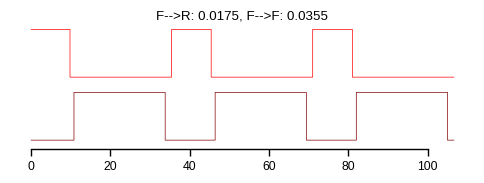

In [35]:
fig, ax = plt.subplots(2, 1, figsize=(2 * ncycles, 1.5), sharex=True, sharey=True)
# make x axis time...
ax[1].step(np.arange(len(plt_fluo)) / fs * 1e3, plt_fluo, color=[0.5, 0, 0], lw=0.5)
ax[0].step(np.arange(len(plt_fluo)) / fs * 1e3, plt_reflect, color=[1, 0, 0], lw=0.5)
# ax[1].set_ylim(-.1, 1)
# for _ax in ax:
# _ax.axis("off")

sns.despine(offset=5, trim=True)
ax[0].set_title(f"F-->R: {fluo_to_reflect_time:.04f}, F-->F: {fluo_to_fluo_time:.04f}")
ax[0].spines["left"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].tick_params(axis='x', length=0)

# ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
fig.savefig(os.path.join(fig_dir, f"multiplex_schematic_{cycle_type}.pdf"), bbox_inches="tight")

In [36]:
use_metadata = toml.load(os.path.join(fluo_dir, "..", "metadata.toml"))
# cameras = list(use_metadata["camera_metadata"].keys())
load_cameras = use_cameras

In [37]:
load_dct = {}
for _cam in load_cameras:
    load_dct[_cam] = {}
    load_dct[_cam]["intrinsic_matrix"] = np.array(calibration_data["intrinsics"][_cam]) # ADJUST FOR CROP?
    load_dct[_cam]["distortion_coeffs"] = np.array(calibration_data["distortion_coeffs"][_cam]) # ADJUST FOR CROP?

In [38]:
# get a blank and a high intensity animal...
(
    fluo_frames,
    reflect_frames,
    _,
    _,
    _,
) = load_example_frames(fluo_dir, frame_range=range(100,110), bground_subtract_fluorescence=False, load_cameras=load_cameras, segmentation_dir=None, load_dct=load_dct) # 0 looks pretty good...

/tmp/conda-stage-5hnt/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-5hnt/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-5hnt/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/tmp/conda-stage-5hnt/data_analysis/lib/python3.10/site-packages/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or d

In [39]:
h, w = fluo_frames[_cam][0].shape

In [40]:
multiplier = 2

0it [00:00, ?it/s]

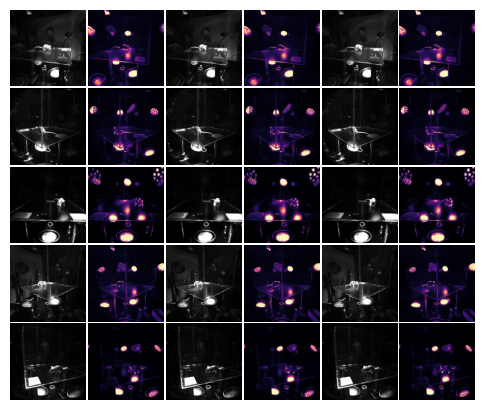

In [41]:
if cycle_type == "slow":
    reflect_kwargs = {"cmap": "gray", "vmin": 0, "vmax": 125}
    fluo_kwargs = {"cmap": "magma", "vmin": 0, "vmax": 75}
else:
    eflect_kwargs = {"cmap": "gray", "vmin": 0, "vmax": 255}
    fluo_kwargs = {"cmap": "magma", "vmin": 0, "vmax": 150}
    
fig, ax = plt.subplots(len(use_cameras), ncycles * 2, figsize=(ncycles * multiplier,len(use_cameras) * (h / w)), sharex=True, sharey=True)
for rax, _cam in tqdm(zip(ax, use_cameras)):
    for i, _ax in enumerate(rax):
        frame_idx = i // 2
        if i % 2 == 0:
            _ax.imshow(reflect_frames[_cam][frame_idx], **reflect_kwargs)
        else:
            _ax.imshow(fluo_frames[_cam][frame_idx], **fluo_kwargs)

for _ax in ax.ravel():
    _ax.axis("off")

if cycle_type == "slow":
    fig.subplots_adjust(hspace=.015, wspace=.03)
else:
    fig.subplots_adjust(hspace=.03, wspace=.01)

fig.savefig(os.path.join(fig_dir, f"multiplex_schematic_frames_{cycle_type}.pdf"), bbox_inches="tight", dpi=600)